# CEE 690-02

# Environmental Spatial Data Analysis

# Lecture 8

# Logistics

* The final project groups need to have 4 members.
* If your group is not finalized by Tuesday, we will create the groups at random in class then.

# Outline

* Covariance
* Autocorrelation
* Correlation coefficients
* Trend analysis
* Cumulative distribution function (CDF) matching

# Covariance

Measure of the joint variability of random variables $X$ and $Y$. 

The sample covariance is given by:

$$\text{cov}(X,Y) = \frac{1}{n}\sum_{i=1}^n(x_i - \bar{x})(y_i - \bar{y})$$

Note that the variance is simply the covariance of $X$ with itself.

$$\text{var}(X) = \text{cov}(X,X) = \frac{1}{n}\sum_{i=1}^n(x_i - \bar{x})^2$$

# Pearson correlation coefficient: Revisited

The Pearson correlation coefficient is simply a normalized covariance. 

$$\rho = \frac{\text{cov}(X,Y)}{\sqrt{\text{var}(X)}\sqrt{\text{var}(Y)}} = \frac{\text{cov}(X,Y)}{\sigma_X\sigma_Y} = \frac{\sum_{i=1}^n(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{{\sum_{i=1}^n(x_i - \bar{x})^2}}\sqrt{{\sum_{i=1}^n(y_i - \bar{y})^2}}}$$

Where $\sigma_X$ and $\sigma_Y$ are the standard deviation of $X$ and $Y$ respectively.


# Autocorrelation

The prefix "auto" in autocorrelation denotes correlation of a variable with itself. The temporal autocorrelation indicates the correlation of a variable with its own future and past values. Autocorrelations are generally computed using the Pearson correlation coefficient.

Let's look at the autocorrelation of simulated monthly soil temperature in Durham, NC from the NLDAS database we introduced on Tuesday

First, we need to read in the corresponding data 

In [77]:
#Import the corresponding libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
#Open access to the files and bring in the dates
file = '/data/NLDASv2/NLDAS_NOAH0125_M.002.nc'
fp = nc.Dataset(file)
dates = nc.num2date(fp['time'][:],units=fp['time'].units,calendar='standard')
tmp = []
for date in dates:
    tmp.append(datetime.datetime(date.year,date.month,1))
dates = np.array(tmp)

In [78]:
#Let's extract the monthly time series for Durham
lat = 35.9940
lon = -78.8986
lats = fp['lat'][:]
lons = fp['lon'][:]
ilat = np.argmin(np.abs(lats - lat))
ilon = np.argmin(np.abs(lons - lon))
m = (dates >= datetime.datetime(1979,1,1)) & (dates <= datetime.datetime(2018,12,31))
tsoil0_10cm = fp['tsoil0_10cm'][m,ilat,ilon]

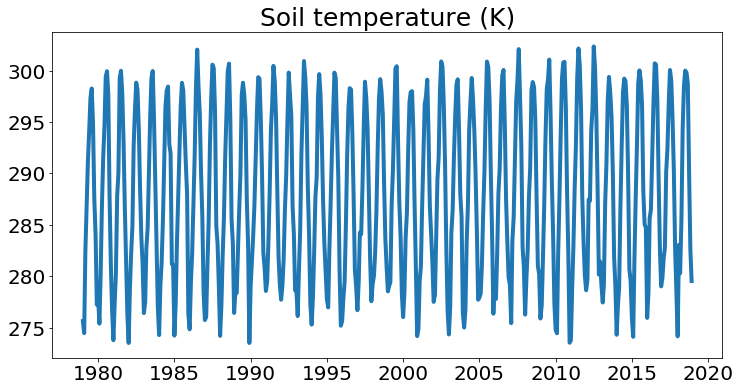

In [88]:
plt.figure(figsize=(12,6))
plt.plot(dates[m],tsoil0_10cm,lw=4)
plt.title('Soil temperature (K)',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

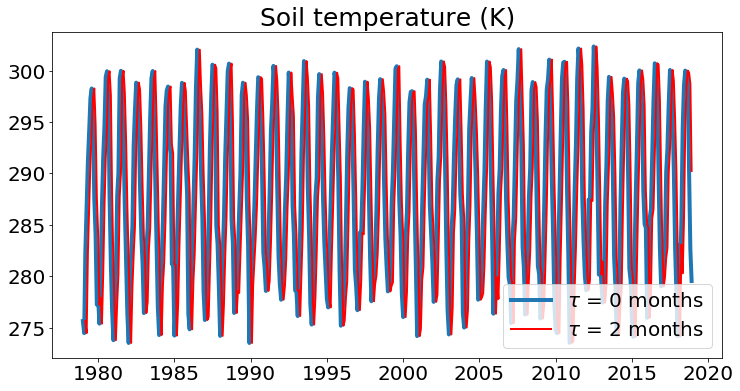

In [94]:
#Let's overlay the same time series but shifted two months later (time delay tau of two months)
plt.figure(figsize=(12,6))
plt.plot(dates[m],tsoil0_10cm,lw=4)
plt.plot(dates[m][2:],tsoil0_10cm[:-2],'r',lw=2)
plt.title('Soil temperature (K)',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend([r'$\tau$ = 0 months',r'$\tau$ = 2 months'],fontsize=20)
plt.show()

Let's compute the serial correlation at multiple time delays and save the results

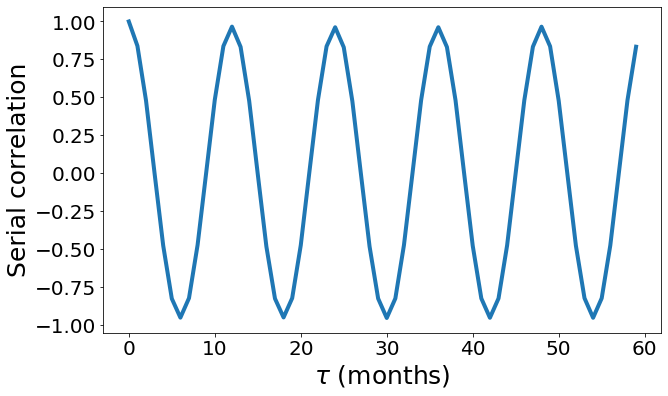

In [95]:
import scipy.stats
taus = np.arange(0,5*12) #months
vals = []
for tau in taus:
    if tau == 0:val = 1.0
    else: val = scipy.stats.pearsonr(tsoil0_10cm[:-tau],tsoil0_10cm[tau:])[0]
    vals.append(val)
plt.figure(figsize=(10,6))
plt.plot(taus,vals,lw=4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Serial correlation',fontsize=25)
plt.xlabel(r'$\tau$ (months)',fontsize=25)
plt.show()

Let's compute the 1 month delay ($\tau$ = 1 month) serial correlation for soil temperature across the entire NLDAS domain.

In [5]:
tsoil0_10cm_conus = np.ma.getdata(fp['tsoil0_10cm'][m,:,:])

In [6]:
import scipy.stats

def compute_serial_correlation(data,tau):
    output = np.zeros((data.shape[1],data.shape[2]))
    output[:] = -9999.0
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            if data[0,i,j] == -999000000.0:continue
            output[i,j] = scipy.stats.pearsonr(data[tau:,i,j],data[:-tau,i,j])[0]
    return output

conus_tsoil_tau1 = compute_serial_correlation(tsoil0_10cm_conus,1)

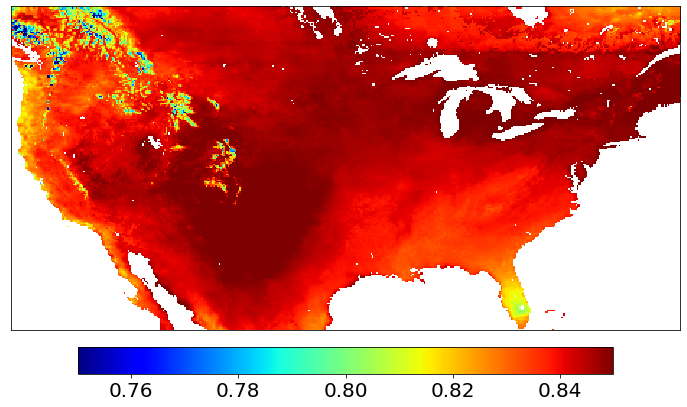

In [7]:
#Mask out -9999 values
conus_tsoil_tau1 = np.ma.masked_array(conus_tsoil_tau1,conus_tsoil_tau1==-9999)
plt.figure(figsize=(12,8))
plt.imshow(np.flipud(conus_tsoil_tau1),cmap=plt.get_cmap('jet'),vmin=0.75,vmax=0.85)
cb = plt.colorbar(orientation='horizontal',shrink=0.8,pad=0.04)
cb.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.show()

# Revisit correlation

In [96]:
#Let's extract the monthly time series for Durham,NC and Asheville,NC
lat_durham = 35.9940
lon_durham = -78.8986
lat_asheville = 35.5951
lon_asheville = -82.5515
lats = fp['lat'][:]
lons = fp['lon'][:]
ilat_durham = np.argmin(np.abs(lats - lat_durham))
ilon_durham = np.argmin(np.abs(lons - lon_durham))
ilat_asheville = np.argmin(np.abs(lats - lat_asheville))
ilon_asheville = np.argmin(np.abs(lons - lon_asheville))
m = (dates >= datetime.datetime(1979,1,1)) & (dates <= datetime.datetime(2018,12,31))
tsoil0_10cm_durham = fp['tsoil0_10cm'][m,ilat_durham,ilon_durham]
tsoil0_10cm_asheville = fp['tsoil0_10cm'][m,ilat_asheville,ilon_asheville]

In [97]:
#Let's upscale to annual time step
tsoil0_10cm_durham_annual = []
tsoil0_10cm_asheville_annual = []
imin = 0
imax = 12
for year in range(1979,2019):
    tsoil0_10cm_durham_annual.append(np.mean(tsoil0_10cm_durham[imin:imax]))
    tsoil0_10cm_asheville_annual.append(np.mean(tsoil0_10cm_asheville[imin:imax]))
    imin = imin + 12
    imax = imax + 12
tsoil0_10cm_durham_annual = np.array(tsoil0_10cm_durham_annual)
tsoil0_10cm_asheville_annual = np.array(tsoil0_10cm_asheville_annual)

Linear correlation: 0.93


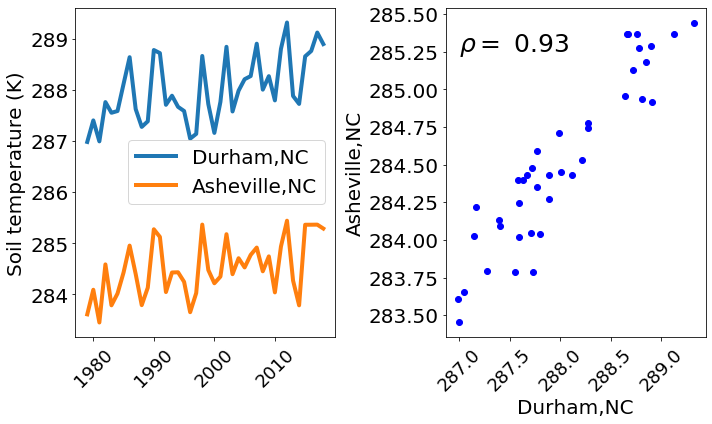

In [99]:
#Make some plots
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(np.arange(1979,2019),tsoil0_10cm_durham_annual,lw=4)
plt.plot(np.arange(1979,2019),tsoil0_10cm_asheville_annual,lw=4)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.ylabel('Soil temperature (K)',fontsize=20)
plt.legend(['Durham,NC','Asheville,NC'],fontsize=20)
plt.subplot(122)
plt.plot(tsoil0_10cm_durham_annual,tsoil0_10cm_asheville_annual,'bo')
val = scipy.stats.pearsonr(tsoil0_10cm_durham_annual,tsoil0_10cm_asheville_annual)[0]
print('Linear correlation: %.2f' %val)
plt.text(287,285.25,r'$\rho = $ %.2f' % val,fontsize=25)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.xlabel('Durham,NC',fontsize=20)
plt.ylabel('Asheville,NC',fontsize=20)
plt.tight_layout()
plt.show()

Let's add an outlier to our Asheville data and then do the same comparison

Pearson correlation (Original): 0.93
Pearson correlation (Modified): 0.72


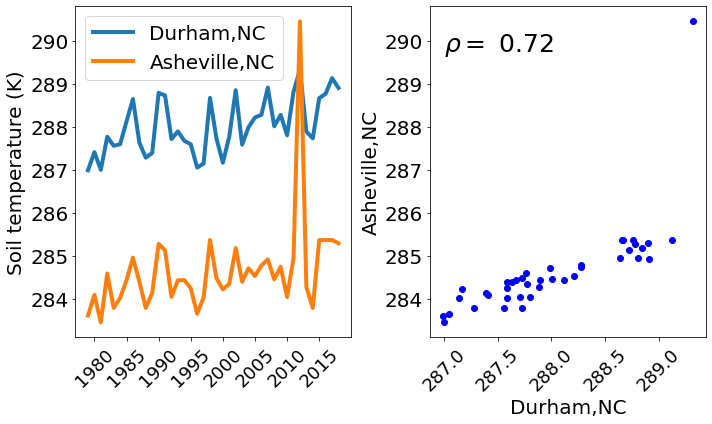

In [100]:
#Copy the data and add an outlier at index 33
tmp = np.copy(tsoil0_10cm_asheville_annual)
tmp[33] = tmp[33] + 5
#Make some plots
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(np.arange(1979,2019),tsoil0_10cm_durham_annual,lw=4)
plt.plot(np.arange(1979,2019),tmp,lw=4)
#plt.title('Soil temperature (K)',fontsize=25)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.ylabel('Soil temperature (K)',fontsize=20)
plt.legend(['Durham,NC','Asheville,NC'],fontsize=20)
plt.subplot(122)
plt.plot(tsoil0_10cm_durham_annual,tmp,'bo')
val = scipy.stats.pearsonr(tsoil0_10cm_durham_annual,tsoil0_10cm_asheville_annual)[0]
print('Pearson correlation (Original): %.2f' %val)
val = scipy.stats.pearsonr(tsoil0_10cm_durham_annual,tmp)[0]
print('Pearson correlation (Modified): %.2f' %val)
plt.text(287,289.75,r'$\rho = $ %.2f' % val,fontsize=25)
#plt.title('Soil temperature (K)',fontsize=25)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.xlabel('Durham,NC',fontsize=20)
plt.ylabel('Asheville,NC',fontsize=20)
plt.tight_layout()
plt.show()

Pearson correlations are notoriously sensitive to outliers in our data. A strong relationship between two series might exist, but an outlier throws off the signal when calculating the Pearson correlation. 

# Alternative I: Spearman rank correlation

The Spearman rank correlation is the Pearson correlation coefficient computed using the ranks of the data instead of the data itself. This ensures that outliers lose strength when comparing two series. 

The equation for calculating the Spearman rank correlation can be simplified to:

$$\rho_{rank} = 1 - \frac{6\sum_{i=1}^n D_i^2}{n(n^2-1)}$$

Where $D_i$ is the difference in ranks between the $i^{th}$ pair of data values. 

Source: Wilks, 2006

## Examples of Spearman vs Pearson (Source: Wikipedia)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Spearman_fig1.svg/600px-Spearman_fig1.svg.png" width="400">


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Spearman_fig2.svg/600px-Spearman_fig2.svg.png" width="400">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Spearman_fig3.svg/600px-Spearman_fig3.svg.png" width="400">

Let's revisit our outlier example

Spearman rank correlation (Original): 0.90
Spearman rank correlation (Modified): 0.90


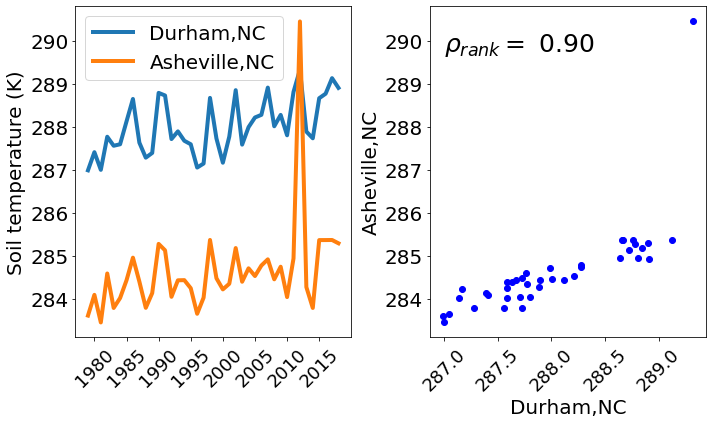

In [102]:
tmp = np.copy(tsoil0_10cm_asheville_annual)
tmp[33] = tmp[33] + 5
#Make some plots
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(np.arange(1979,2019),tsoil0_10cm_durham_annual,lw=4)
plt.plot(np.arange(1979,2019),tmp,lw=4)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.ylabel('Soil temperature (K)',fontsize=20)
plt.legend(['Durham,NC','Asheville,NC'],fontsize=20)
plt.subplot(122)
plt.plot(tsoil0_10cm_durham_annual,tmp,'bo')
rho_rank = scipy.stats.spearmanr(tsoil0_10cm_durham_annual,tsoil0_10cm_asheville_annual)[0]
print('Spearman rank correlation (Original): %.2f' % rho_rank)
rho_rank = scipy.stats.spearmanr(tsoil0_10cm_durham_annual,tmp)[0]
print('Spearman rank correlation (Modified): %.2f' % rho_rank)
plt.text(287,289.75,r'$\rho_{rank} = $ %.2f' % rho_rank,fontsize=25)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.xlabel('Durham,NC',fontsize=20)
plt.ylabel('Asheville,NC',fontsize=20)
plt.tight_layout()
plt.show()

# Alternative II: Kendall's $\tau$

Kendall's $\tau$ is calculated by considering the relationships among all possible mathcings of the data pairs ($x_i$,$y_i$), of which there are $n(n-1)/2$) in a sample of size $n$. 

Any matching in which both members of one pair are larger than their counterparts in the other pair is called concordant. For example, the pairs (3,8) and (7,83) would be concordant while the pairs (3,83) and (7,8) would be discordant). 

Kendall's $\tau$ is given by:

$$ \tau = \frac{N_C - N_D}{n(n-1)/2)} $$

Where $N_C$ is the number of concordant pairs and $N_D$ is the number of discordant pairs.

Source: Wilks, 2006

Kendalls tau (Original): 0.74
Kendalls tau (Modified): 0.74


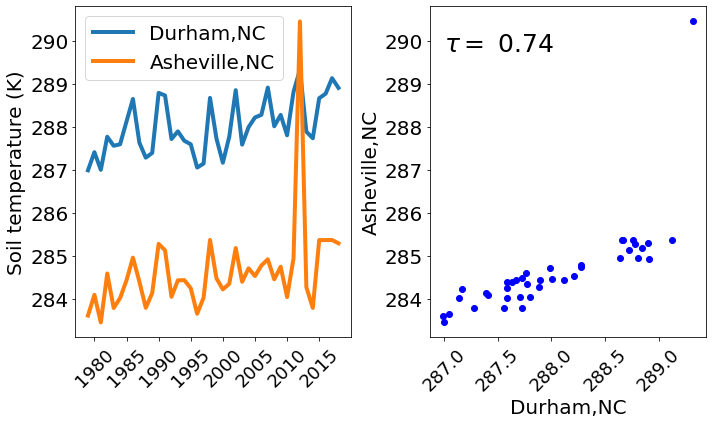

In [104]:
tmp = np.copy(tsoil0_10cm_asheville_annual)
tmp[33] = tmp[33] + 5
#Make some plots
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(np.arange(1979,2019),tsoil0_10cm_durham_annual,lw=4)
plt.plot(np.arange(1979,2019),tmp,lw=4)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.ylabel('Soil temperature (K)',fontsize=20)
plt.legend(['Durham,NC','Asheville,NC'],fontsize=20)
plt.subplot(122)
plt.plot(tsoil0_10cm_durham_annual,tmp,'bo')
rho_rank = scipy.stats.kendalltau(tsoil0_10cm_durham_annual,tsoil0_10cm_asheville_annual)[0]
print(r'Kendalls tau (Original): %.2f' % rho_rank)
rho_rank = scipy.stats.kendalltau(tsoil0_10cm_durham_annual,tmp)[0]
print(r'Kendalls tau (Modified): %.2f' % rho_rank)
plt.text(287,289.75,r'$\tau = $ %.2f' % rho_rank,fontsize=25)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.xlabel('Durham,NC',fontsize=20)
plt.ylabel('Asheville,NC',fontsize=20)
plt.tight_layout()
plt.show()

### Example: Compare the Contiguous United States to Durham

In [14]:
#Let's upscale to annual time step
tsoil0_10cm_conus_annual = []
imin = 0
imax = 12
for year in range(1979,2019):
    tsoil0_10cm_conus_annual.append(np.mean(tsoil0_10cm_conus[imin:imax,:,:],axis=0))
    imin = imin + 12
    imax = imax + 12
tsoil0_10cm_conus_annual = np.array(tsoil0_10cm_conus_annual)

In [16]:
#Compute the pearson correlation, spearman correlation, and Kendall's tau 
#between Durham's time series and all of the contiguous United States
def compute_correlation(data,data_point):
    output = {'kendall':np.zeros((data.shape[1],data.shape[2])),
              'pearson':np.zeros((data.shape[1],data.shape[2])),
              'spearman':np.zeros((data.shape[1],data.shape[2]))}
    for var in output:
        output[var][:] = -9999.0
    for i in range(data.shape[1]):
        if i% 20 == 0:print('row:',i)
        for j in range(data.shape[2]):
            if data[0,i,j] < 0:continue
            output['kendall'][i,j] = scipy.stats.kendalltau(data[:,i,j],data_point)[0]
            output['pearson'][i,j] = scipy.stats.pearsonr(data[:,i,j],data_point)[0]
            output['spearman'][i,j] = scipy.stats.spearmanr(data[:,i,j],data_point)[0]
    return output

corrs = compute_correlation(tsoil0_10cm_conus_annual,tsoil0_10cm_durham_annual)

row: 0
row: 1
row: 2
row: 3
row: 4
row: 5
row: 6
row: 7
row: 8
row: 9
row: 10
row: 11
row: 12
row: 13
row: 14
row: 15
row: 16
row: 17
row: 18
row: 19
row: 20
row: 21
row: 22
row: 23
row: 24
row: 25
row: 26
row: 27
row: 28
row: 29
row: 30
row: 31
row: 32
row: 33
row: 34
row: 35
row: 36
row: 37
row: 38
row: 39
row: 40
row: 41
row: 42
row: 43
row: 44
row: 45
row: 46
row: 47
row: 48
row: 49
row: 50
row: 51
row: 52
row: 53
row: 54
row: 55
row: 56
row: 57
row: 58
row: 59
row: 60
row: 61
row: 62
row: 63
row: 64
row: 65
row: 66
row: 67
row: 68
row: 69
row: 70
row: 71
row: 72
row: 73
row: 74
row: 75
row: 76
row: 77
row: 78
row: 79
row: 80
row: 81
row: 82
row: 83
row: 84
row: 85
row: 86
row: 87
row: 88
row: 89
row: 90
row: 91
row: 92
row: 93
row: 94
row: 95
row: 96
row: 97
row: 98
row: 99
row: 100
row: 101
row: 102
row: 103
row: 104
row: 105
row: 106
row: 107
row: 108
row: 109
row: 110
row: 111
row: 112
row: 113
row: 114
row: 115
row: 116
row: 117
row: 118
row: 119
row: 120
row: 121
row: 122
row

Let's create some plots with the computed correlations

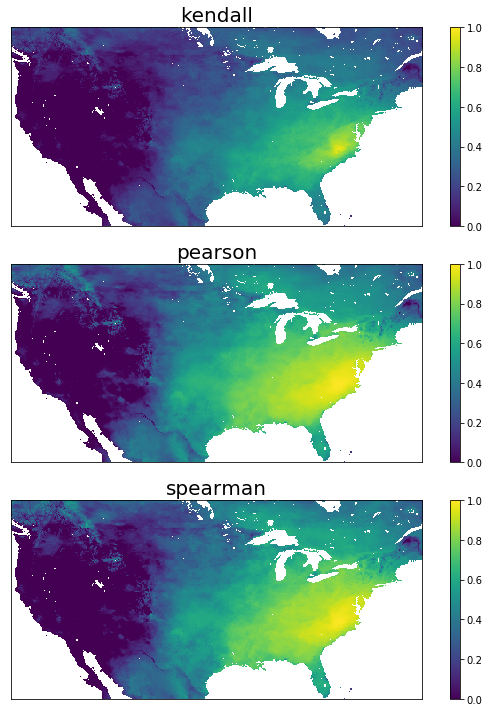

In [105]:
i = 0
plt.figure(figsize=(8,10))
for var in corrs:
    i+=1
    #Let's first mask out the undefined values (-9999)
    data = np.ma.masked_array(corrs[var],corrs[var]==-9999)
    #Now we will make the plot
    plt.subplot(3,1,i)
    plt.imshow(np.flipud(data),vmin=0,vmax=1)
    plt.title(var,fontsize=20)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
plt.tight_layout()
plt.show()

## Correlation coefficients summary
* Pearson correlation reflects the strength of linear relationships
* Spearman rank correlation reflects the strength of monotone relationships
* Kendall's $\tau$ also reflects the strength of monotone relationships
* Both the Spearman rank correlation and Kendall's $\tau$ are non-parametric; thus no assumption is made about the distribution from whi

In general, Kendall's $\tau$ iand the Spearman rank correlations are non-parametric. Kendall's $\tau$ is generally considered to be best; however, either choices are far superior to the Pearson correlation coefficient.

Note that the interpretability of the values of each metric cannot be truly compared to each other.

# Trend analysis

How do we quantify the apparent trend in the data?

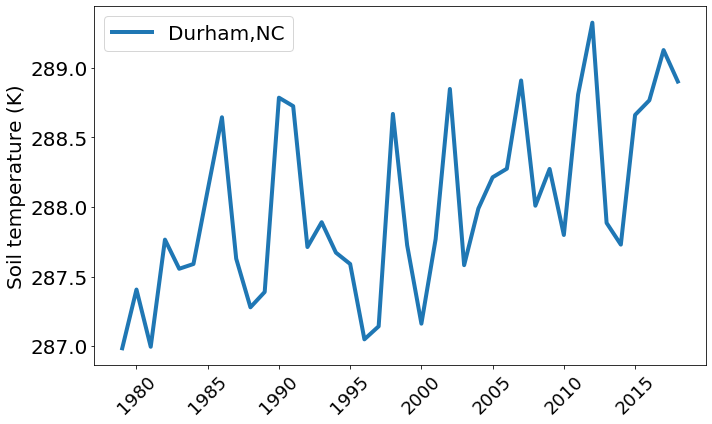

In [106]:
#Plot the annual time series of soil temperature
plt.figure(figsize=(10,6))
plt.plot(np.arange(1979,2019),tsoil0_10cm_durham_annual,lw=4)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.ylabel('Soil temperature (K)',fontsize=20)
plt.legend(['Durham,NC','Asheville,NC'],fontsize=20)
plt.tight_layout()
plt.show()

## Linear regression

<img src="https://bookdown.org/sbikienga/Intro_to_stat_book/images/chap7/ols.jpg" width="600">

Source: https://bookdown.org/sbikienga/Intro_to_stat_book

Let's fit a line to our data in Durham and plot the fitted line

In [108]:
years = np.arange(1979,2019)
(slope, intercept, r_value, p_value, std_err) = scipy.stats.linregress(years,tsoil0_10cm_durham_annual)
print('slope:',slope,'K/year')
print('intercept:',intercept,'K')

slope: 0.03099354069407393 K/year
intercept: 226.067648668987 K


In [109]:
#Make the prediction
tpred = intercept + slope*years

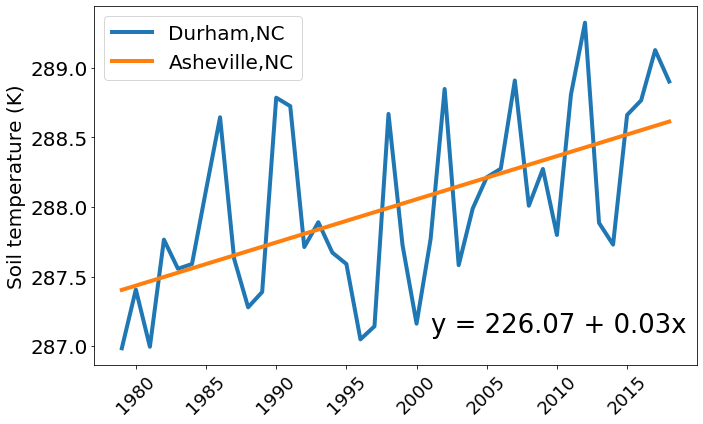

In [110]:
#Plot the annual time series of soil temperature and the prediction
plt.figure(figsize=(10,6))
plt.plot(years,tsoil0_10cm_durham_annual,lw=4)
plt.plot(years,tpred,lw=4)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.ylabel('Soil temperature (K)',fontsize=20)
plt.legend(['Durham,NC','Asheville,NC'],fontsize=20)
plt.text(2001,287.1,'y = %.2f + %.2fx' % (intercept,slope),fontsize=26)
plt.tight_layout()
plt.show()

Compute the linear trend over CONUS

In [64]:
#Compute the linear trend
def compute_linear_trend_simple_linear_regression(x,data):
    output = np.zeros((data.shape[1],data.shape[2]))
    #Initialize to undefined value of -9999
    output[:] = -9999.0
    for i in range(data.shape[1]):
        if i% 20 == 0:print('row:',i)
        for j in range(data.shape[2]):
            if data[0,i,j] < 0:continue
            (slope, intercept, r_value, p_value, std_err) = scipy.stats.linregress(x,data[:,i,j])
            output[i,j] = slope
    return output

years = np.arange(1979,2019)
slope_slr = compute_linear_trend_simple_linear_regression(years,tsoil0_10cm_conus_annual)

row: 0
row: 20
row: 40
row: 60
row: 80
row: 100
row: 120
row: 140
row: 160
row: 180
row: 200
row: 220


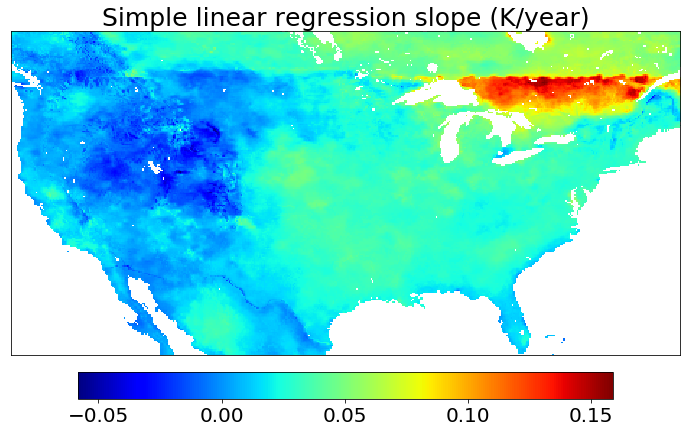

In [75]:
#Mask out -9999 values
slope_slr_masked = np.ma.masked_array(slope_slr,slope_slr==-9999)
plt.figure(figsize=(12,8))
plt.imshow(np.flipud(slope_slr_masked),cmap=plt.get_cmap('jet'))#,vmin=0.75,vmax=0.85)
cb = plt.colorbar(orientation='horizontal',shrink=0.8,pad=0.04)
cb.ax.tick_params(labelsize=20)
plt.title('Simple linear regression slope (K/year)',fontsize=25)
plt.xticks([])
plt.yticks([])
plt.show()

The discontinuity between the USA and Canada is what happens when you combine meteorological data from two different countries to run your land surface model...

Simple linear regression can lead to problems very quickly. Let's revisit the Durham example by introducing an outlier.

slope: 0.043657705797263434
intercept: 200.88331471026277


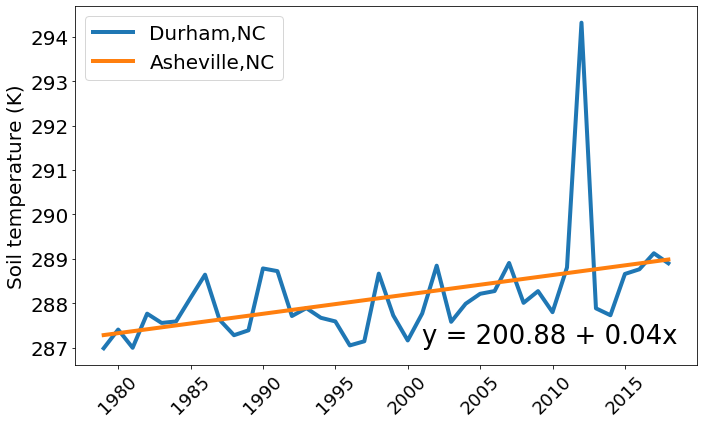

In [111]:
years = np.arange(1979,2019)
#Introduce an outlier
tsoil0_10cm_durham_annual_mod = np.copy(tsoil0_10cm_durham_annual)
tsoil0_10cm_durham_annual_mod[33] = tsoil0_10cm_durham_annual_mod[33] + 5
#Fit a line using simple linear regression
(slope, intercept, r_value, p_value, std_err) = scipy.stats.linregress(years,tsoil0_10cm_durham_annual_mod)
print('slope:',slope)
print('intercept:',intercept)
#Make the prediction
tpred = intercept + slope*years
#Plot the annual time series of soil temperature and the prediction
plt.figure(figsize=(10,6))
plt.plot(years,tsoil0_10cm_durham_annual_mod,lw=4)
plt.plot(years,tpred,lw=4)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.ylabel('Soil temperature (K)',fontsize=20)
plt.legend(['Durham,NC','Asheville,NC'],fontsize=20)
plt.text(2001,287.1,'y = %.2f + %.2fx' % (intercept,slope),fontsize=26)
plt.tight_layout()
plt.show()

Outliers can strongly impact the calculated linear trend

## Alternative: Theil-Sen estimator

Analogous to Kendall's $\tau$, we compute the slope of the line for each pair and then use the median of the computed slopes and intercepts as the final estimate of the slope and intercept. 

slope: 0.03316073947482639
intercept: 221.56993696424695


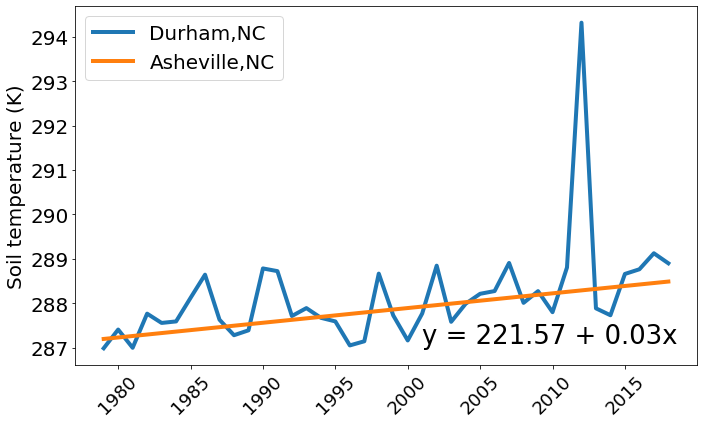

In [60]:
years = np.arange(1979,2019)
tsoil0_10cm_durham_annual_mod = np.copy(tsoil0_10cm_durham_annual)
tsoil0_10cm_durham_annual_mod[33] = tsoil0_10cm_durham_annual_mod[33] + 5
(slope, intercept, low_slope, high_slope) = scipy.stats.theilslopes(tsoil0_10cm_durham_annual_mod,years)
print('slope:',slope)
print('intercept:',intercept)
#Make the prediction
tpred = intercept + slope*years
#Plot the annual time series of soil temperature and the prediction
plt.figure(figsize=(10,6))
plt.plot(years,tsoil0_10cm_durham_annual_mod,lw=4)
plt.plot(years,tpred,lw=4)
plt.xticks(fontsize=18,rotation=45)
plt.yticks(fontsize=20)
plt.ylabel('Soil temperature (K)',fontsize=20)
plt.legend(['Durham,NC','Asheville,NC'],fontsize=20)
plt.text(2001,287.1,'y = %.2f + %.2fx' % (intercept,slope),fontsize=26)
plt.tight_layout()
plt.show()

Let's compute the Theil-Sen estimator over CONUS

In [63]:
#Compute the linear trend
def compute_linear_trend_theil_sen(x,data):
    output = np.zeros((data.shape[1],data.shape[2]))
    #Initialize to undefined value of -9999
    output[:] = -9999.0
    for i in range(data.shape[1]):
        if i% 20 == 0:print('row:',i)
        for j in range(data.shape[2]):
            if data[0,i,j] < 0:continue
            (slope, intercept, low, high) = scipy.stats.theilslopes(data[:,i,j],x)
            output[i,j] = slope
    return output

years = np.arange(1979,2019)
slope_ts = compute_linear_trend_theil_sen(years,tsoil0_10cm_conus_annual)

row: 0
row: 20
row: 40
row: 60
row: 80
row: 100
row: 120
row: 140
row: 160
row: 180
row: 200
row: 220


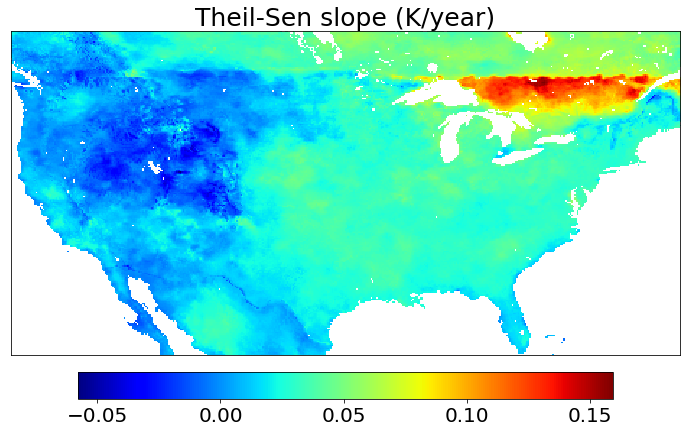

In [74]:
#Mask out -9999 values
slope_ts_masked = np.ma.masked_array(slope_ts,slope_ts==-9999)
plt.figure(figsize=(12,8))
plt.imshow(np.flipud(slope_ts_masked),cmap=plt.get_cmap('jet'))#,vmin=0.75,vmax=0.85)
cb = plt.colorbar(orientation='horizontal',shrink=0.8,pad=0.04)
cb.ax.tick_params(labelsize=20)
plt.title('Theil-Sen slope (K/year)',fontsize=25)
plt.xticks([])
plt.yticks([])
plt.show()

Let's compare the map of slopes from simple linear regression with those from the Theil-Sen estimator

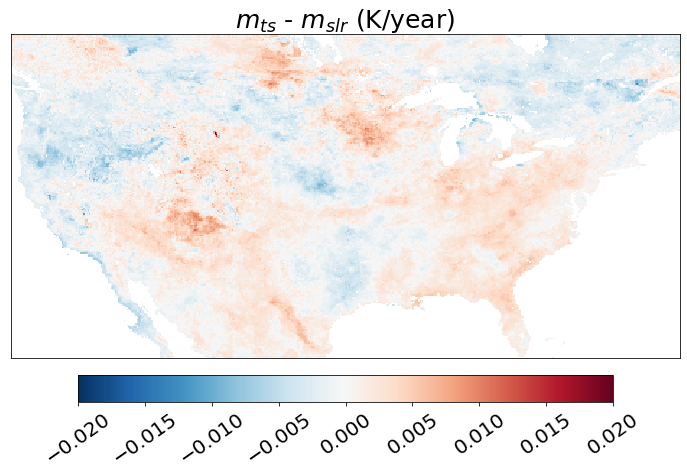

In [76]:
plt.figure(figsize=(12,8))
#Subtract the simple linear regression slopes from the theil-sen estimator slopes
slope_diff = slope_ts_masked - slope_slr_masked
plt.imshow(np.flipud(slope_diff),cmap=plt.get_cmap('RdBu_r'),vmin=-0.02,vmax=0.02)
cb = plt.colorbar(orientation='horizontal',shrink=0.8,pad=0.04)
cb.ax.tick_params(labelsize=20,rotation=35)
plt.title('$m_{ts}$ - $m_{slr}$ (K/year)',fontsize=25)
plt.xticks([])
plt.yticks([])
plt.show()

**Trend analysis conclusion**: Although it requires more computation, when estimating linear trends, using the Sen-Theil approach (or other existing similarly robust approaches) is strongly encouraged over the use of simple linear regression.

# Applications of probability in correcting climate models

In [113]:
#Read in ERA-Interim
import netCDF4 as nc
#Let's read in the annual mean precipitation, wind speed, temperature, and pressure from ERA-Interim
file = '/data/era-interim/era_interim_monthly_197901_201512_upscaled.nc_ann'
#Let's read in the annual mean precipitation, specific humidity, temperature, and pressure from ERA-Interim
fp = nc.Dataset(file)
output_era = {}
output_era['t_ref'] = 273.15 + fp['t2m'][:]
times = fp['time']
output_era['dates'] = nc.num2date(times[:],units=times.units,calendar=times.calendar)
fp.close()

In [115]:
#Let's read in the annual mean precipitation, specific humidity, temperature, and pressure from ERA-Interim
output_gfdl = {}
file = '/data/GFDL/atmos.1980-2014.t_ref.nc_ann'
fp = nc.Dataset(file)
output_gfdl['t_ref'] = fp['t_ref'][:]
times = fp['time']
output_gfdl['dates'] = nc.num2date(times[:],units=times.units,calendar=times.calendar)
fp.close()

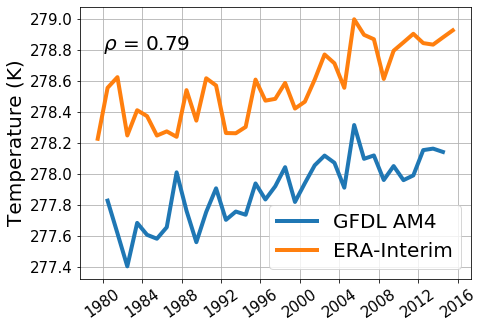

In [206]:
#Compute masks
dates_gfdl = output_gfdl['dates']
dates_era = output_era['dates']
m_gfdl = (dates_gfdl >= datetime.datetime(1980,1,1)) & (dates_gfdl <= datetime.datetime(2014,1,31))
m_era = (dates_era >= datetime.datetime(1980,1,1)) & (dates_era <= datetime.datetime(2014,1,31))

#Compare global time series
var = 't_ref'
fig = plt.figure(figsize=(7,5))
tref_am4 = np.mean(np.mean(output_gfdl[var],axis=1),axis=1)
tref_era = np.mean(np.mean(output_era[var],axis=1),axis=1)
plt.plot(output_gfdl['dates'],tref_am4,lw=4)
plt.plot(output_era['dates'],tref_era,lw=4)
plt.legend(['GFDL AM4','ERA-Interim'],fontsize=20)
plt.text(datetime.datetime(1980,1,1),278.8,
        r'$\rho$ = %.2f' % scipy.stats.pearsonr(tref_am4[m_gfdl],tref_era[m_era])[0],fontsize=20)
plt.ylabel('Temperature (K)',fontsize=20)
plt.xticks(fontsize=15,rotation=35)
plt.yticks(fontsize=15)
plt.grid('on')
plt.show()

The correlation is good, but there is a clear bias. How could we fix it?

Let's compare both the histogram and empirical CDF of both time series

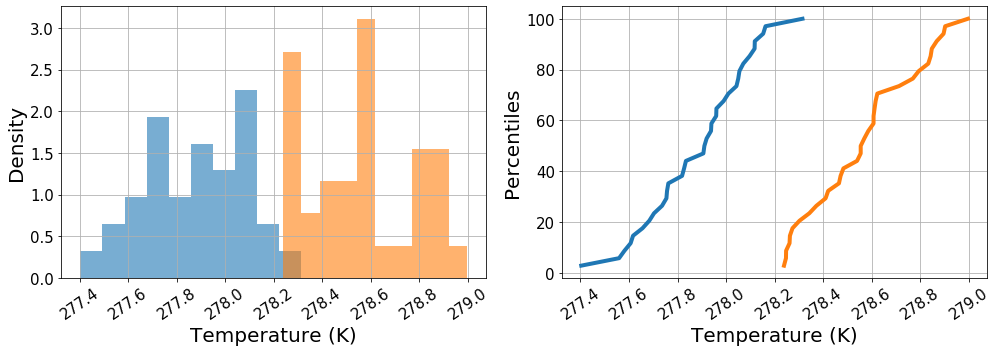

In [207]:
def compute_ecdf(data):
    x = np.sort(data)
    n = x.size
    #Use weibull plotting positions
    y = 100*np.arange(1, n+1) / n
    return(x,y)

#Compare global time series
var = 't_ref'
fig = plt.figure(figsize=(14,5))
plt.subplot(121)
tref_am4 = np.mean(np.mean(output_gfdl[var],axis=1),axis=1)
tref_era = np.mean(np.mean(output_era[var],axis=1),axis=1)
tref_am4 = tref_am4[m_gfdl]
tref_era = tref_era[m_era]
plt.hist(tref_am4,bins=10,density=1,alpha=0.6)
plt.hist(tref_era,bins=10,density=1,alpha=0.6)
plt.xlabel('Temperature (K)',fontsize=20)
plt.ylabel('Density',fontsize=20)
plt.xticks(fontsize=15,rotation=35)
plt.yticks(fontsize=15)
plt.grid('on')
plt.subplot(122)
(scores_am4,pcts_am4) = compute_ecdf(tref_am4)
plt.plot(scores_am4,pcts_am4,lw=4)
(scores_era,pcts_era) = compute_ecdf(tref_era)
plt.plot(scores_era,pcts_era,lw=4)
plt.xlabel('Temperature (K)',fontsize=20)
plt.ylabel('Percentiles',fontsize=20)
plt.xticks(fontsize=15,rotation=35)
plt.yticks(fontsize=15)
plt.grid('on')
plt.tight_layout()
plt.show()

If we want to correct the modeled temperature, what if we just match its distribution to that of the observations (i.e., ERA-Interim)?

# Data assimilation example: CDF matching

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Histogram_matching.PNG/440px-Histogram_matching.PNG" width="700">



CDF matching is as simple as having percentile $x$ of distribution 1 take the value of percentile $x$ of distribution 2. 

In [208]:
#This is a very crude function of how to do this. There are much more efficient ways
def cdf_match(vals1,vals2):
    #Here 1 is the distribution that will be matched to 2
    vals1_matched = []
    for i in range(vals1.size):
        pct1 = scipy.stats.percentileofscore(vals1,vals1[i])
        #Extract the score the "correct cdf" at the given percentile
        vals1_matched.append(np.percentile(vals2,pct1,interpolation='nearest'))
    return vals1_matched
        
tref_am4_corrected = cdf_match(tref_am4,tref_era)

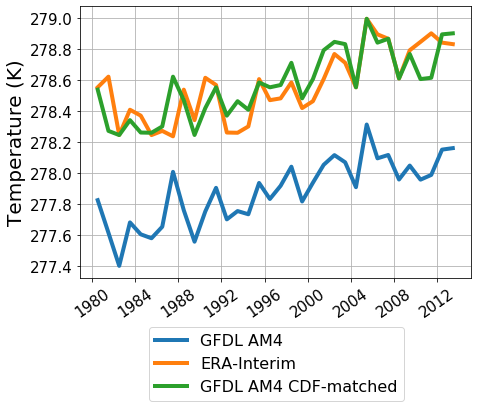

In [223]:
#Compare global time series
var = 't_ref'
fig = plt.figure(figsize=(7,5))
plt.plot(output_gfdl['dates'][m_gfdl],tref_am4,lw=4)
plt.plot(output_era['dates'][m_era],tref_era,lw=4)
plt.plot(output_era['dates'][m_era],tref_am4_corrected,lw=4)
plt.legend(['GFDL AM4','ERA-Interim','GFDL AM4 CDF-matched'],fontsize=16,bbox_to_anchor=(0.15, -0.65, 0.7, 0.5))
plt.ylabel('Temperature (K)',fontsize=20)
plt.xticks(fontsize=15,rotation=35)
plt.yticks(fontsize=15)
plt.grid('on')
plt.show()

It works but be very careful. You have to assume that the distribution does not change which is highly problematic if you assume a changing climate.

In [ ]:
We are done with the intro to Probability and Statistics module. Basically all methods that can be applied to a time series can be used on spatial data that have a time component. It just requires m

# Next week: Map projections!